In [1]:
import random
from typing import List, Union, Callable, Tuple

In [2]:
Number = Union[int, float]
Matrix = List[List[Number]]
Vector = List[Number]
Tensor = Union[Matrix, Vector]
LossFunction = Callable[[Vector, Vector, bool], Union[Number, Vector]]

## Tensor operations

In [3]:
def tensor_addition(A: Tensor, B: Tensor) -> Tensor:
    """Elementwise sum between two 2D matrices of the same shape.

    Args:
        A (Tensor): A Tensor
        B (Tensor): B Tensor

    Returns:
        (Tensor): Tensor with elementwise summed elements
    """
    assert len(A) == len(B)
    out = []
    for i in range(len(A)):
        if isinstance(A[i], list):
            assert len(A[i]) == len(B[i])
            tmp = []
            for j in range(len(A[i])):
                tmp.append(A[i][j] + B[i][j])
        else:
            tmp = A[i] + B[i]
        out.append(tmp)
    return out

In [4]:
def matvec(W: Matrix, x: Vector) -> Vector:
    """Multiple 2D Matrix and column vector.

    output = Wx + b

    Args:
        W (Matrix): (Weight) Matrix
        x (Vector): Column vector

    Returns:
        (Vector): Matrix-vector product
    """
    Wx = []
    for row in W:
        assert len(row) == len(x)
        Wx.append(sum([row[i] * x[i] for i in range(len(x))]))
    return Wx

In [5]:
def transpose(A: Matrix) -> Matrix:
    """Transpose 2D Matrix.

    Args:
        A (Matrix): A matrix

    Return:
        (Matrix): Matrix transpose
    """
    n = len(A)
    m = len(A[0])
    initialise_zeros = lambda n, m: [[0] * m for i in range(n)]
    out = initialise_zeros(m, n)
    for i in range(n):
        for j in range(m):
            out[j][i] = A[i][j]
    return out

In [6]:
def scalar_multiply(alpha: Number, v: Tensor) -> Tensor:
    """Multiply all elements of a N-D Tensor with a scalar value.

    Args:
        alpha: Scalar value
        v: Multidimensional Tensor

    Returns:
        Tensor with same shape as original, with each element multiplied by scalar
    """
    if isinstance(v, list):
        return [scalar_multiply(alpha, x) for x in v]
    else:
        return alpha * v

In [7]:
def hadamard(a: list, b: list):
    """Hadamard Product"""
    assert len(a) == len(b)
    acc = []
    for i in range(len(a)):
        acc.append(a[i] * b[i])

    return acc

## Neural Network initialisation

In [8]:
def init_layer(n: int, m: int) -> Tuple[Matrix, Vector]:
    """Initialise an empty layer with n imputs and m outputs.

    Args:
        n: Size of the input vector
        m: Size of the output vector

    Returns:
        (Tuple[Matrix, Vector]): Initialised weights (m x n) matrix
            and biases (m x 1) vector for the layer
    """
    W = []
    b = []
    for _ in range(m):
        b.append(random.random())
        row = []
        for _ in range(n):
            row.append(random.random())
        W.append(row)
    return W, b

In [9]:
def init_NN(*layers: int):
    """Initialise the weights and biases for the fully connected neural network.

    The network must contain at least two layers (input and output).

    Args:
        layers (int): The number of nodes within each layer.

    Returns:
        (List[Matrix], List[Vector]): Lists of weights and biases for the network.
    """
    assert len(layers) > 1
    Ws = []
    bs = []
    for dim in list(zip(layers[:-1], layers[1:])):
        W, b = init_layer(*dim)
        Ws.append(W)
        bs.append(b)
    return Ws, bs

## Neural Network operations

In [10]:
def forward(x: Vector, weights: List[Matrix], biases: List[Vector]) -> List[Vector]:
    """Forward pass through the neural network.

    Args:
        x: Input vector
        weights (List[Matrix]): Neural network weights
        biases (List[Vector]): Neural network biases

    Returns:
        (List[Vector]): Output for each layer in the network
    """

    xs = [x]
    for i in range(len(weights)):
        x = matvec(weights[i], x)
        x = tensor_addition(x, biases[i])
        xs.append(x)
    return xs

In [11]:
def MSE(
    y: Vector, target: Vector, derivative: bool = False
) -> Union[float, List[float]]:
    """Mean Square Error between network output vector and target vector.

    Args:
        y (Vector): Network output vector
        target (Vector): Target vector
        derivative (bool): Flag to calculate derivate of loss function for backpropagation

    Returns:
        (Union[float,List[float]]): Either the loss scalar for a single vector,
            or the delta errors vector for backprop

    """
    assert len(y) == len(target)
    if derivative:
        return [(2 / len(y)) * (y[i] - target[i]) for i in range(len(y))]
    diff = [(target[i] - y[i]) ** 2 for i in range(len(y))]
    return sum(diff) / len(diff)

In [12]:
def dCdw(delta: Vector, o_i: Vector) -> Matrix:
    """Calculate the derivative of the Cost function with respect to the weight matrix.

    Outer product of input from the previous layer with the error from the output
    dC/dx_ij = o_j*delta_i

    Args:
        delta: Output error vector based on the derivative of the Cost function.
        o_i: input to the layer

    Returns:
        (Matrix): Derivative of Cost with respect to the weights

    """
    delta_C = []
    for j in range(len(delta)):
        tmp = []
        for i in range(len(o_i)):
            tmp.append(o_i[i] * delta[j])
        delta_C.append(tmp)
    return delta_C

In [20]:
def backprop(
    weights: List[Matrix],
    biases: List[Vector],
    y: Vector,
    target: Vector,
    loss_fn: LossFunction,
    learning_rate: float,
):
    """Propagate error back through network weights and biases.

    Args:
        weights (List[Matrix]): Weight matrices of the neural network to update
        biases (List[Vector], optional): Optional biases to update
        y (Vector): Network output vector
        target (Vector): Target vector
        loss_fn (LossFunction): Loss function with respect to which the gradients are calculated

    Returns:
        Tuple[List[Matrix],List[Vector]]: Updated weights and biases

    """
    new_weights = []
    new_biases = []
    dl = loss_fn(y[-1], target, derivative=True)
    for i in reversed(range(len(weights))):
        new_weight = tensor_addition(
            scalar_multiply(-1 * learning_rate, dCdw(dl, y[i])), weights[i]
        )
        new_bias = tensor_addition(scalar_multiply(-1 * learning_rate, dl), biases[i])
        new_weights.append(new_weight)
        new_biases.append(new_bias)
        dl = matvec(transpose(weights[i]), dl)

    return list(reversed(new_weights)), list(reversed(new_biases))

## Run Neural Network

#### Define test data

In [14]:
xs = [[random.randint(0, 9) for _ in range(3)] for _ in range(500)]
ys = [[4 * x[0] + x[1] + x[2]] for x in xs]

In [15]:
from itertools import cycle

in_cycle = cycle(xs)
target_cycle = cycle(ys)

#### Run epochs

In [16]:
LEARNING_RATE = 0.0001

In [21]:
num_epochs = 500
weights, biases = init_NN(3, 3, 3, 1)
losses = []
for i in range(num_epochs):
    x = next(in_cycle)
    target = next(target_cycle)
    _out = forward(x, weights, biases)
    loss = MSE(_out[-1], target)
    losses.append(loss)
    weights, biases = backprop(weights, biases, _out, target, MSE, LEARNING_RATE)
    if i % (num_epochs // 20) == 0:
        print(loss)
    if loss < 1e-10:
        break
weights

968.9202177944546
3.466022148095932
49.90062091299476
0.39261666898784064
1.0379483557030562
10.738162417610882
0.20337811881151505
0.25592253208325766
0.9205492815954703
0.12695372819452996
0.0507282810603192
0.509644285183728
0.12187228339550771
0.15233539071318225
0.0001966397863048252
0.5514500705897312
0.08844190696479137
0.02968836319735766
0.008638368257962667
0.013971981916877983


[[[0.8755442619027709, 0.04076106356448584, 0.6662058244929537],
  [1.0646941174441416, 0.3200627467021175, -0.12494724235149554],
  [0.7606209449248398, 0.30241670951129057, 0.11673223799168402]],
 [[0.08027103826790549, 0.2498306635446614, 0.38586930593543356],
  [0.876031874186343, 1.0868682767680151, 0.7787912165055424],
  [0.7635051696758953, 0.24882575574019952, 0.16336799711490668]],
 [[0.19014258168345155, 1.3383244451030567, 0.4231517451983102]]]

In [22]:
import matplotlib.pyplot as plt

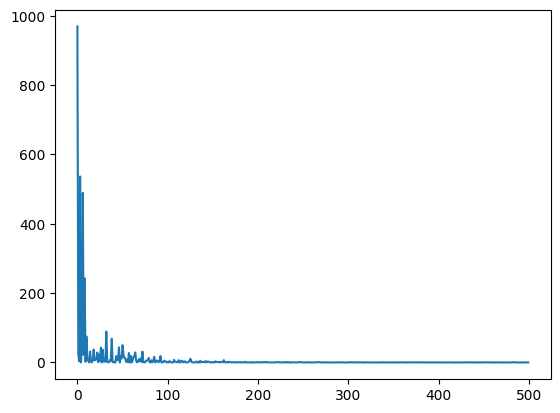

In [23]:
plt.plot(range(len(losses)), losses)